<a href="https://colab.research.google.com/github/ndrep/bioinformatics/blob/main/Bioinformatic_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount drive

In [1]:
from google.colab import drive

drive.mount("/drive/")

Mounted at /drive/


#Installing requirements

In [2]:
!pip install -q "cache_decorator[all]"==2.0.8 humanize scikit-learn
!pip install -q barplots plot_keras_history epigenomic_dataset>=1.1.7
!pip install -q ucsc_genomes_downloader>=1.1.22 keras_bed_sequence>=1.1.5
!pip install -q keras_mixed_sequence ray seaborn minepy boruta prince cmake
!pip install -q multicoretsne silence_tensorflow>=1.1.1
!pip install tsnecuda==3.0.0+cu110 -f https://tsnecuda.isx.ai/tsnecuda_stable.html --no-dependencies
!pip install -q faiss tbb
!pip install extra_keras_metrics

     |████████████████████████████████| 98 kB 4.3 MB/s 
     |████████████████████████████████| 57.6 MB 1.4 MB/s 
     |████████████████████████████████| 495 kB 42.8 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 119 kB 47.9 MB/s 
Looking in links: https://tsnecuda.isx.ai/tsnecuda_stable.html
     |████████████████████████████████| 55.4 MB 1.3 MB/s 
     |████████████████████████████████| 4.7 MB 5.4 MB/s 
     |████████████████████████████████| 4.0 MB 28.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsnecuda 3.0.0+cu110 requires faiss==1.6.5, but you have faiss 1.5.3 which is incompatible.
  Created wheel for extra-keras-metrics: filename=extra_keras_metrics-2.0.5-py3-none-any.whl size=14204 sha256=f1da404d223e75631f980794153caf99501b899b81c8a08f67c7ca0443c7f582
  Stored in directory: /root/.cache

#Import packages

In [3]:
from typing import Dict, List, Tuple, Optional
from cache_decorator import Cache
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.colors import ListedColormap, LogNorm
from multiprocessing import cpu_count, Pool
import matplotlib.pyplot as plt
from epigenomic_dataset.utils import get_cell_lines
from typing import Tuple
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from extra_keras_metrics import get_complete_binary_metrics
from tsnecuda import TSNE

# Import Epigenomic Data

In [4]:
cell_line='MCF-7'   

In [5]:
from epigenomic_dataset import active_promoters_vs_inactive_promoters, active_enhancers_vs_inactive_enhancers

X_AP_vs_IP, y_AP_vs_IP= active_promoters_vs_inactive_promoters(cell_line=cell_line, binarize=True)
X_AE_vs_IE, y_AE_vs_IE=active_enhancers_vs_inactive_enhancers(cell_line=cell_line, binarize=True)

samples = {
    'promoter':X_AP_vs_IP,
    'enhancer':X_AE_vs_IE
}

labels = {
    'promoter':y_AP_vs_IP, 
    'enhancer':y_AE_vs_IE
}

In [6]:
labels['promoter']

MCF7
chrom chromStart chromEnd  strand       
chr1  628964     629220    +       False
      629013     629269    +       False
      629642     629898    +       False
      629847     630103    +       False
      629905     630161    +       False
...                                  ...
chrX  154441877  154442133 +       False
      154584927  154585183 +       False
chrY  1452882    1453138   -       False
      2500959    2501215   -       False
      14055973   14056229  +       False

[99881 rows x 1 columns]

# Data Cleaning

Evaluation of ratio between samples and features.

In [7]:
samples['promoter'].shape[0] / samples['promoter'].shape[1]

853.6837606837607

In [8]:
samples['enhancer'].shape[0] / samples['enhancer'].shape[1]

540.8974358974359

### Nan Imputation

X dataset have 182 nan values and it could be imputed with KNNImputer

In [9]:
samples['promoter'].isna().sum().sum()

182

In [10]:
labels['promoter'].isna().sum().sum()

0

In [11]:
samples['enhancer'].isna().sum().sum()

0

In [12]:
labels['enhancer'].isna().sum().sum()

0

In [13]:
from sklearn.impute import KNNImputer

def knn_imputation(df:pd.DataFrame, neighbours:int=5, weights:str='uniform')->pd.DataFrame:
    """Return provided dataframe with NaN imputed using knn.
    
    Parameters
    --------------------
    df:pd.DataFrame,
        The dataframe to impute.
    neighbours:int=5,
        The number of neighbours to consider.
    weights:str='uniform',
        Weight function used in prediction.
        
    Returns
    --------------------
    The dataframe with the NaN values imputed.
    """
    return pd.DataFrame(
        KNNImputer(n_neighbors=neighbours, weights=weights).fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [14]:
for region in samples.items():
  samples[region[0]] = knn_imputation(samples[region[0]])

In [15]:
for region in samples.items():
  print('Nan values in {} is {}'.format(region[0], samples[region[0]].isna().sum().sum()))

Nan values in promoter is 0
Nan values in enhancer is 0


### Drop Constant features

In [16]:
def drop_constant_features(df:pd.DataFrame)->pd.DataFrame:
    """Return DataFrame without constant features."""
    return df.loc[:, (df != df.iloc[0]).any()]

In [17]:
dropped_promoter = drop_constant_features(samples['promoter'])
dropped_enhancer = drop_constant_features(samples['enhancer'])

Check if some features hes been drop

In [18]:
dropped_promoter.shape != samples['promoter'].shape

False

In [19]:
dropped_enhancer.shape != samples['enhancer'].shape

False

In [20]:
samples['promoter'] = dropped_promoter
samples['enhancer'] = dropped_enhancer

### Data Scaling

In [21]:
from sklearn.preprocessing import RobustScaler

def robust_zscoring(df:pd.DataFrame)->pd.DataFrame:
    """Return given dataframe scaled using robust z-scoring."""
    return pd.DataFrame(
        RobustScaler().fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [22]:
samples['promoter'] = robust_zscoring(samples['promoter'])
samples['enhancer'] = robust_zscoring(samples['enhancer'])

### Class Balance

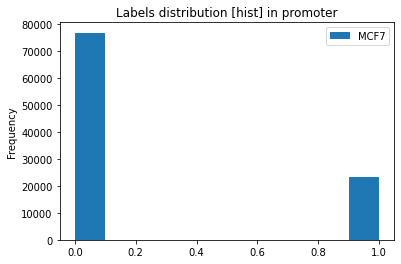

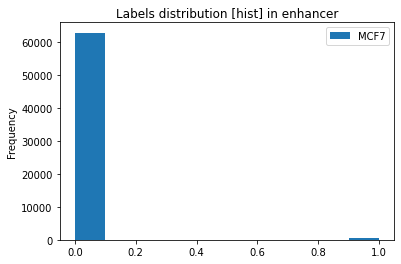

In [23]:
for (region, y) in labels.items():
  y.astype(int).plot.hist(title=f"Labels distribution [hist] in {region}")



In [25]:
for (region, y) in labels.items():
  print("active {} are {}% respect to total class".format(region, (y['MCF7'][y['MCF7']==True].count()*100) / y['MCF7'][y['MCF7']==False].count()))

active promoter are 30.10929175296677% respect to total class
active enhancer are 0.6344814426104379% respect to total class


The classes, overall enhancer class, are very unbalance, but we don't will balance the classes like write in [Bayesian optimization improves tissue-specific prediction of active regulatory regions with deep neural networks](https://gvalentinib.ariel.ctu.unimi.it/v5/frm3/Download.aspx?toolName=contenuti&attachmentid=1037727) paper.

# Features Correlation & Features Selection

In [ ]:
p_value_threshold = 0.01
correlation_threshold = 0.05

In [ ]:
not_correlated_features = {'promoter':set(), 'enhancer':set()}

### Linear correlation with Pearson index


In [ ]:
from scipy.stats import pearsonr

for (X,y) in zip(samples.items(), labels.items()):
  for feature in tqdm(X[1].columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
    correlation, p_value = pearsonr(X[1][feature].values.flatten(), y[1].values.flatten())
    if p_value > p_value_threshold:
      print(f"In {X[0]} the feature {feature} does not correlate in a statistically significant manner with the output. p-value:{p_value} -- correlation:{correlation}")
      not_correlated_features[X[0]].add(feature)

Running Pearson test:   0%|          | 0/429 [00:00<?, ?it/s]

In promoter the feature ZNF785 does not correlate in a statistically significant manner with the output. p-value:0.19871785034981493 -- correlation:-0.004066654904761061


Running Pearson test:   0%|          | 0/429 [00:00<?, ?it/s]

In enhancer the feature STAG1 does not correlate in a statistically significant manner with the output. p-value:0.3141878715909758 -- correlation:-0.004000909943252502
In enhancer the feature RBM34 does not correlate in a statistically significant manner with the output. p-value:0.056719734028049994 -- correlation:0.007574479426943351
In enhancer the feature XRCC3 does not correlate in a statistically significant manner with the output. p-value:0.1593637387971633 -- correlation:0.005593905774975099
In enhancer the feature ZKSCAN3 does not correlate in a statistically significant manner with the output. p-value:0.03622268875911463 -- correlation:0.00832557407709118
In enhancer the feature ILK does not correlate in a statistically significant manner with the output. p-value:0.8013449567695253 -- correlation:-0.0010001854970581206
In enhancer the feature ZNF830 does not correlate in a statistically significant manner with the output. p-value:0.02747520052310545 -- correlation:-0.008763936

### Linear correlation with Spearman index

In [ ]:
from scipy.stats import spearmanr

for (X,y) in zip(samples.items(), labels.items()):
  for feature in tqdm(X[1].columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
    correlation, p_value = spearmanr(X[1][feature].values.flatten(), y[1].values.flatten())
    if p_value > p_value_threshold:
      print(f"In {X[0]} the feature {feature} does not correlate in a statistically significant manner with the output. p-value:{p_value} -- correlation:{correlation}")
      not_correlated_features[X[0]].add(feature)

Running Pearson test:   0%|          | 0/429 [00:00<?, ?it/s]

In promoter the feature THRAP3 does not correlate in a statistically significant manner with the output. p-value:0.45022669526267045 -- correlation:0.0023890854986367126
In promoter the feature NCOA4 does not correlate in a statistically significant manner with the output. p-value:0.6184910831799564 -- correlation:0.0015757392600128511


Running Pearson test:   0%|          | 0/429 [00:00<?, ?it/s]

In enhancer the feature STAG1 does not correlate in a statistically significant manner with the output. p-value:0.5131594854997283 -- correlation:-0.0025994774489953715
In enhancer the feature RBM34 does not correlate in a statistically significant manner with the output. p-value:0.05350256208344028 -- correlation:0.0076753570217031886
In enhancer the feature XRCC3 does not correlate in a statistically significant manner with the output. p-value:0.0500927021246367 -- correlation:0.007787966266958954
In enhancer the feature ZKSCAN3 does not correlate in a statistically significant manner with the output. p-value:0.019003237568436065 -- correlation:0.009323482474508819
In enhancer the feature ILK does not correlate in a statistically significant manner with the output. p-value:0.6561100776264117 -- correlation:-0.001770112808444864
In enhancer the feature ZNF830 does not correlate in a statistically significant manner with the output. p-value:0.03971774570989607 -- correlation:-0.0081755

In [ ]:
not_correlated_features

{'enhancer': {'ATF2',
  'DLX4',
  'EWSR1',
  'FOXA1',
  'FOXJ3',
  'H3K36me3',
  'H3K9me3',
  'HNRNPH1',
  'ILK',
  'MCM2',
  'MCM7',
  'NFE2L1',
  'PCBP2',
  'RBM15',
  'RBM17',
  'RBM34',
  'RFX1',
  'SAFB2',
  'SNRNP70',
  'SRSF7',
  'STAG1',
  'THRA',
  'U2AF2',
  'XRCC3',
  'ZBTB8A',
  'ZKSCAN3',
  'ZNF280A',
  'ZNF318',
  'ZNF408',
  'ZNF778',
  'ZNF830',
  'whole-genome shotgun bisulfite sequencing'},
 'promoter': {'NCOA4', 'THRAP3', 'ZNF785'}}

### Not linear correlation with MIC

In [ ]:
from minepy import MINE

if os.path.exists('/drive/MyDrive/not_linear_correlation_json.json'):
  with open('/drive/MyDrive/not_linear_correlation_json.json', 'r') as fp:
      not_linear_correlation = json.load(fp)
else:
  not_linear_correlation = {'promoter':set(), 'enhancer':set()}
  for (X,y) in zip(samples.items(), labels.items()):
    for items in not_correlated_features.items():
      for feature in tqdm(items[1], desc=f"Running MINE test", dynamic_ncols=True, leave=False):
          mine = MINE()
          mine.compute_score(X[1][feature].ravel(), y[1].values.ravel())
          score = mine.mic()
          if score < correlation_threshold:
              print(f"In {X[0]} the feature {feature} does not correlate in a statistically significant manner with the output.")
              not_linear_correlation[items[0]].add(feature)
  
  for region in not_linear_correlation.items():
    not_linear_correlation[region[0]] = list(region[1])

  json_object = json.dumps(not_linear_correlation, indent = 4)
  with open('/drive/MyDrive/not_linear_correlation_json.json', 'w') as writefile:
    writefile.write(json_object)

Running MINE test:   0%|          | 0/3 [00:00<?, ?it/s]

The feature NCOA4 does not correlate in a statistically significant manner with the output.
The feature THRAP3 does not correlate in a statistically significant manner with the output.
The feature ZNF785 does not correlate in a statistically significant manner with the output.


Running MINE test:   0%|          | 0/32 [00:00<?, ?it/s]

The feature ZNF830 does not correlate in a statistically significant manner with the output.
The feature MCM7 does not correlate in a statistically significant manner with the output.
The feature FOXA1 does not correlate in a statistically significant manner with the output.
The feature SRSF7 does not correlate in a statistically significant manner with the output.
The feature HNRNPH1 does not correlate in a statistically significant manner with the output.
The feature ZNF318 does not correlate in a statistically significant manner with the output.
The feature SNRNP70 does not correlate in a statistically significant manner with the output.
The feature ZKSCAN3 does not correlate in a statistically significant manner with the output.
The feature THRA does not correlate in a statistically significant manner with the output.
The feature SAFB2 does not correlate in a statistically significant manner with the output.
The feature EWSR1 does not correlate in a statistically significant manner

Running MINE test:   0%|          | 0/3 [00:00<?, ?it/s]

The feature NCOA4 does not correlate in a statistically significant manner with the output.
The feature THRAP3 does not correlate in a statistically significant manner with the output.
The feature ZNF785 does not correlate in a statistically significant manner with the output.


Running MINE test:   0%|          | 0/32 [00:00<?, ?it/s]

The feature ZNF830 does not correlate in a statistically significant manner with the output.
The feature H3K9me3 does not correlate in a statistically significant manner with the output.
The feature MCM7 does not correlate in a statistically significant manner with the output.
The feature FOXA1 does not correlate in a statistically significant manner with the output.
The feature SRSF7 does not correlate in a statistically significant manner with the output.
The feature HNRNPH1 does not correlate in a statistically significant manner with the output.
The feature ZNF318 does not correlate in a statistically significant manner with the output.
The feature SNRNP70 does not correlate in a statistically significant manner with the output.
The feature ZKSCAN3 does not correlate in a statistically significant manner with the output.
The feature THRA does not correlate in a statistically significant manner with the output.
The feature SAFB2 does not correlate in a statistically significant mann

In [ ]:
not_linear_correlation

{'enhancer': {'ATF2',
  'DLX4',
  'EWSR1',
  'FOXA1',
  'FOXJ3',
  'H3K36me3',
  'H3K9me3',
  'HNRNPH1',
  'ILK',
  'MCM2',
  'MCM7',
  'NFE2L1',
  'PCBP2',
  'RBM15',
  'RBM17',
  'RBM34',
  'RFX1',
  'SAFB2',
  'SNRNP70',
  'SRSF7',
  'STAG1',
  'THRA',
  'U2AF2',
  'XRCC3',
  'ZBTB8A',
  'ZKSCAN3',
  'ZNF280A',
  'ZNF318',
  'ZNF408',
  'ZNF778',
  'ZNF830',
  'whole-genome shotgun bisulfite sequencing'},
 'promoter': {'NCOA4', 'THRAP3', 'ZNF785'}}

### Drop features not correlated with output

In [ ]:
for region in samples.items():
  print(region[1].shape)

(99881, 426)
(63285, 397)


In [ ]:
for region in samples.items():
  region[1].drop(list(not_linear_correlation[region[0]]), axis=1, inplace=True)

In [ ]:
for region in samples.items():
  print(region[1].shape)

(99881, 426)
(63285, 397)


### Correlation with features

In [ ]:
from scipy.stats import spearmanr

@Cache(
    cache_path="/drive/MyDrive/correlations/spearmanr/{_hash}.json",
    args_to_ignore=["X"]
)
def compute_spearmanr(
    X:pd.DataFrame,
    feature_left: str,
    feature_right: str,
    cell_line: str,
    region: str
) -> Dict:
    """Returns Spearman correlation.
    
    Implementative details
    ------------------------------
    We may need to recompute this value across
    multiple re-runs of the jupyter notebook,
    so since it takes a bit of time to do so we cache it.
    
    Parameters
    ----------------------
    X:pd.DataFrame,
        The epigenomic data.
    feature_left: str,
        The left features to compute pearson for.
    feature_right: str,
        The right features to compute pearson for.
    cell_line: str,
        The cell line.
    region: str,
        The cis-regulatory region of interest.
    """
    correlation, p_value = spearmanr(
        X[feature_left].values.flatten(),
        X[feature_right].values.flatten(),
    )
    return dict(
        correlation=correlation,
        p_value=p_value
    )

highly_correlated_future = {'promoter':[], 'enhancer':[]}

for X in tqdm(samples.items(), desc=f"Running Spearman test", dynamic_ncols=True, leave=False):
  for feature_left in tqdm(X[1].columns, dynamic_ncols=True, leave=False):
      for feature_right in X[1].columns:
          if feature_left >= feature_right:
              continue
          pearson_result = compute_spearmanr(
              X[1],
              feature_left,
              feature_right,
              cell_line=cell_line,
              region="promoters"
          )
          if pearson_result["p_value"] < p_value_threshold and np.abs(pearson_result["correlation"]) > 0.99:
              correlation = pearson_result["correlation"]
              print(f"The feature {feature_left} is highly correlated with {feature_right} ({correlation}).")
              highly_correlated_future.append(feature_left)

              

Running Spearman test:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/426 [00:00<?, ?it/s]

In [ ]:
for region in samples.items():
  print(region[1].shape)

In [ ]:
for region in samples.items():
  region[1].drop(highly_correlated_future[region[0]], axis=1, inplace=True)

In [ ]:
for region in samples.items():
  print(region[1].shape)

### Features selection with boruta

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from boruta import BorutaPy
from multiprocessing import cpu_count

@Cache(
    cache_path=[
        "boruta/kept_features_{_hash}.json",
        "boruta/discarded_features_{_hash}.json"
    ],
    args_to_ignore=[
        "X_train", "y_train"
    ]
)
def execute_boruta_feature_selection(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    holdout_number: int,
    regression: bool,
    task_name: str,
    max_iter: int = 100
):
    """Returns tuple with list of kept features and list of discared features.
    
    Parameters
    --------------------------
    X_train: pd.DataFrame,
        The data reserved for the input of the training of the Boruta model.
    y_train: np.ndarray,
        The data reserved for the output of the training of the Boruta model.
    holdout_number: int,
        The current holdout number.
    regression: bool,
        Whether the task is a binary classification one (False) or a regression one (True).
    task_name: str,
        The name of the task.
    max_iter: int = 100,
        Number of iterations to run Boruta for.
    """
    # According to the requested task we build either a random forest regressor
    # or a random forest classifier.
    if regression:
        model = RandomForestRegressor(n_jobs=cpu_count(), max_depth=5)
    else:
        model = RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced_subsample', max_depth=5)
    
    # Create the Boruta model
    boruta_selector = BorutaPy(
        # Defining the model that Boruta should use.
        model,
        # We leave the number of estimators to be decided by Boruta
        n_estimators='auto',
        verbose=False,
        alpha=0.05, # p_value
        # In practice one would run at least 100-200 times,
        # until all tentative features are exausted.
        max_iter=max_iter, 
        random_state=42,
    )
    # Fit the Boruta model
    boruta_selector.fit(X_train.values, y_train)
    
    # Get the kept features and discarded features
    kept_features = list(X_train.columns[boruta_selector.support_])
    discarded_features = list(X_train.columns[~boruta_selector.support_])
    
    # Filter out the unused featured.
    return kept_features, discarded_features

# Import Sequence Data

In [26]:
from ucsc_genomes_downloader import Genome

genome = Genome("hg38")

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

In [27]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

# Data visualization with t-SNE or PCA 

### PCA decomposition

In [43]:
from sklearn.decomposition import PCA

def get_pca_decomposition(
    X: pd.DataFrame,
    data_type: str,
    region: str,
    cell_line: str,
    metric: str,
    **kwargs
) -> pd.DataFrame:
    """Return the 2D TSNE decomposition of the given data."""
    return pd.DataFrame(
        PCA(n_components=2).fit_transform(X.values),
        index=X.index
    )

### t-SNE decomposition

In [44]:
from MulticoreTSNE import MulticoreTSNE as UTSNE
from sklearn.decomposition import PCA

def pca(x:np.ndarray, n_components:int=2)->np.ndarray:
    return PCA(n_components=n_components, random_state=42).fit_transform(x)
    
def get_tsne_decomposition(x:np.ndarray, perplexity:int, dimensionality_threshold:int=50, n_components:int=2)->np.ndarray:
    TSNE(
            # Better performance may be achieved with cosine distance,
            # but currently TSNECUDA does not support other metrics.
            # Expecially for the sequence data, cosine distances may be foundamental
            # to get a semantically significant decomposition.
            perplexity= 100,
            n_iter = 1000,
            verbose=True,
        ).fit_transform(X)

In [47]:
tasks = {
    "x":[
        *[
            val.values
            for val in samples.values()
        ]
    ],
    "y":[
        *[
            val.values.ravel()
            for val in labels.values()
        ]
    ],
    "titles":[
        "Epigenomes promoters",
        "Epigenomes enhancers"
    ]
}

tasks


xs = tasks["x"]
ys = tasks["y"]
titles = tasks["titles"]

assert len(xs) == len(ys) == len(titles)

for x, y in zip(xs, ys):
    assert x.shape[0] == y.shape[0]


Computing PCAs:   0%|          | 0/2 [00:00<?, ?it/s]

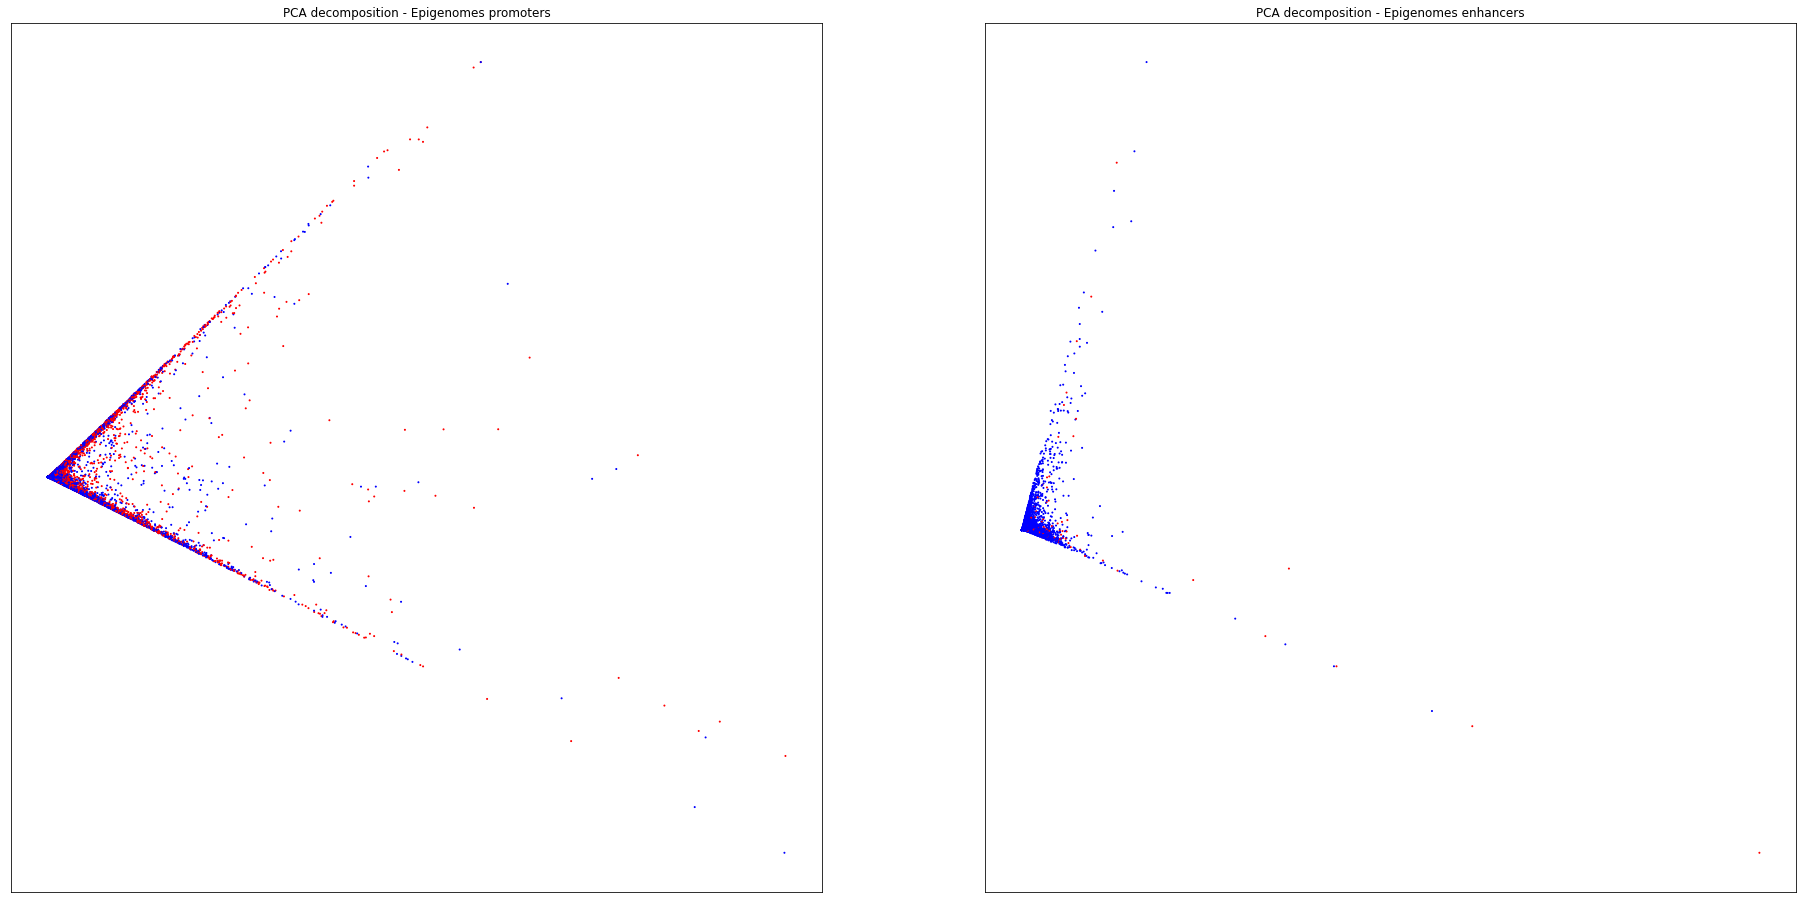

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for x, y, title, axis in tqdm(zip(xs, ys, titles, axes.flatten()), desc="Computing PCAs", total=len(xs)):
    axis.scatter(*pca(x).T, s=1, c=['#ff0000' if i else '#0000ff' for i in y])
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"PCA decomposition - {title}")
plt.show()

In [49]:
import gc
import tsnecuda
from tsnecuda import TSNE
import multiprocessing
from multiprocessing import Process, Queue

Computing PCAs:   0%|          | 0/2 [00:00<?, ?it/s]

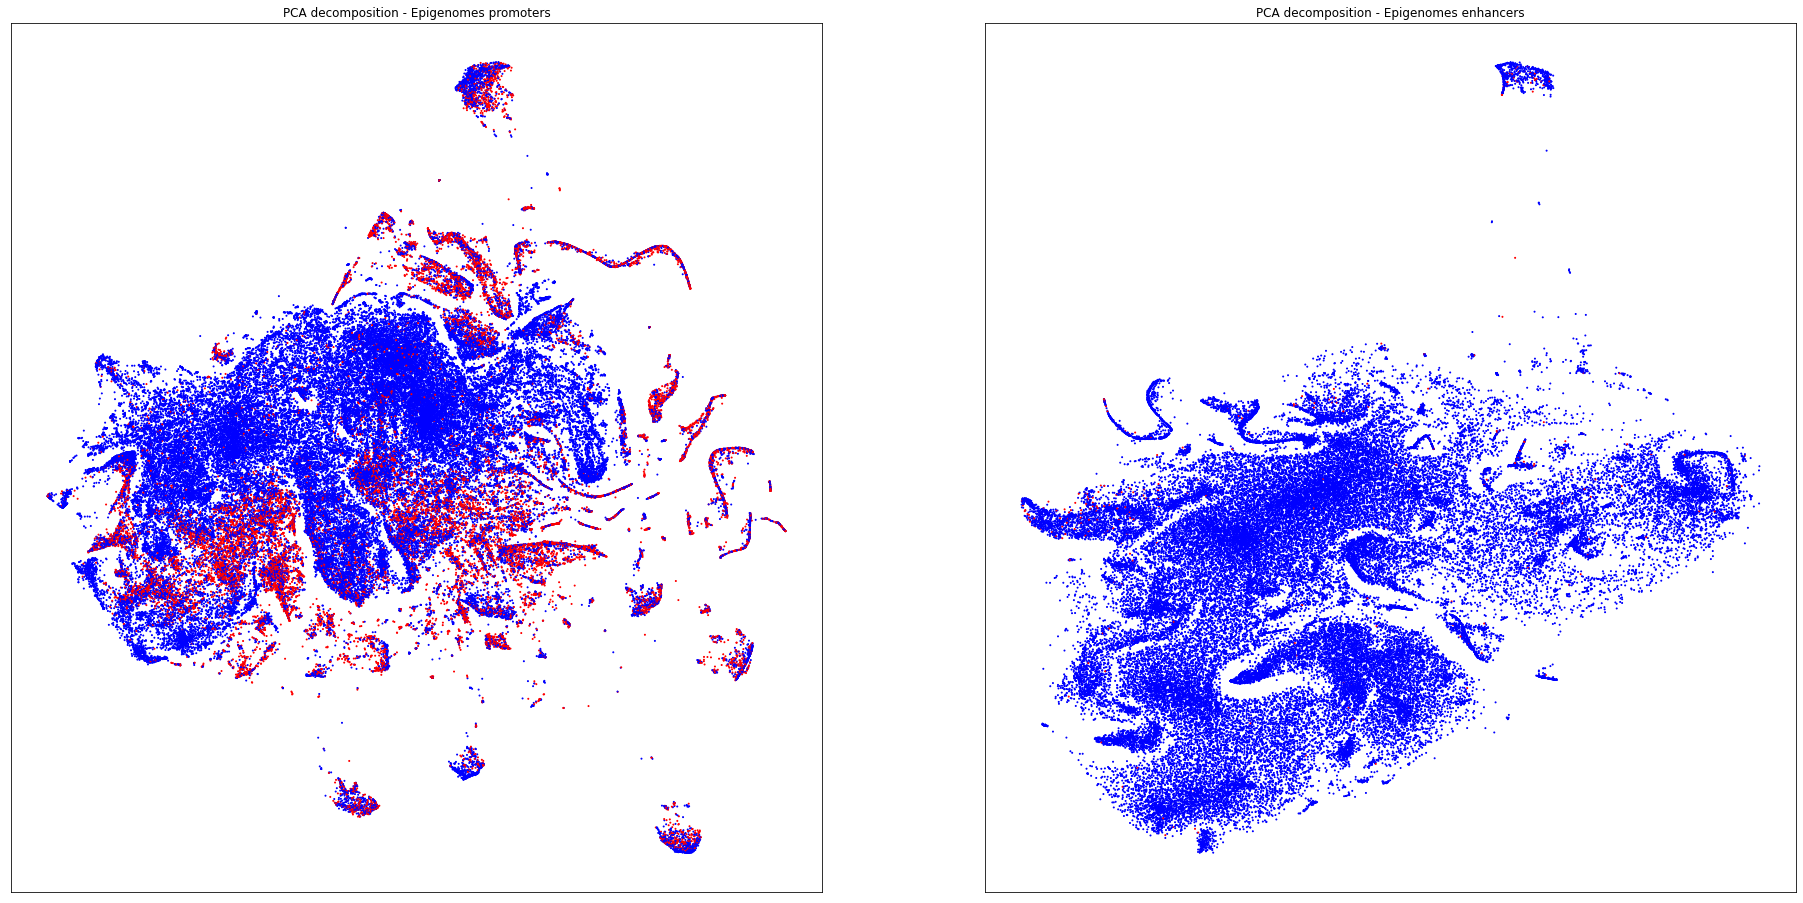

In [50]:
def get_tsne_decomposition1(
    X: pd.DataFrame,
)->pd.DataFrame:
    """Return the 2D TSNE decomposition of the given data."""
    return TSNE(
            # Better performance may be achieved with cosine distance,
            # but currently TSNECUDA does not support other metrics.
            # Expecially for the sequence data, cosine distances may be foundamental
            # to get a semantically significant decomposition.
            perplexity= 100,
            n_iter = 1000,
            verbose=True,
        ).fit_transform(X)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for x, y, title, axis in tqdm(zip(xs, ys, titles, axes.flatten()), desc="Computing PCAs", total=len(xs)):
    axis.scatter(*get_tsne_decomposition1(x).T, s=1, c=['#ff0000' if i else '#0000ff' for i in y])
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"t-SNE decomposition - {title}")
plt.show()